# Laboratorio 1: Clustering

##### **Aprendizaje NO Supervisado** - *Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus aplicaciones.*

El objetivo de este laboratorio es analizar un dataset de textos legales, vectorizarlo y explorar distintas formas de clustering, para poder ver como se agrupan los textos y si tienen algún significado los clusters generados.

El dataset elegido es un dataset provisto por [competencia de metadata de la fundación sadosky](https://metadata.fundacionsadosky.org.ar/competition/2/), titulada Competencia de Etiquetado de Textos Automático. Si bien el ibjetivo de esta competencia es etiquetar textos legales a partir de un conjunto etiquetado, en este laboratorio se plantea no tener en cuenta la etiqueta y analizar el corpus de texto.

Los pasos que se van a realizar en este laboratorio son los siguientes:

 1. Exploración del dataset: análisis de las variables que trae y decidir que variables se utilizarán
 1. Generar Word-Embedding: Con el corpus de texto del dataset, generar un embedding para matchear cada palabra a un espacio de n dimensiones que represente 'mejor' la palabra.
 1. Análisis del Embedding: Analisar el sentido del espacio generado, como matchea las palabras y ver si plabras 'similares' están cerca.
 1. Vectorización del dataset: A partir del embedding generado, vectorizar el dataset de alguna manera a partir de las palabras que tiene cada texto.
 1. Generar métricas para evaluar los posibles clusters a generar: se plantea utilizar las etiquetas dadas por el dataset para generar casos testigos. Por ejemplo, textos que tengan muchas etiquetas en comun, se espera que pertenezcan al mismo cluster y textos con muchas etiquetas distintas, a distintos clusters.
 1. Recorrer diferentes configuraciónes de clusters y analizarlos con los casos testigos.
 1. Explorar los elementos más cercanos a los centroides de los clusters, para ver si existe significado en de los clusters.

In [2]:
%matplotlib inline 
import numpy as np
import pandas as pd
import swifter
import sklearn as sk
import sklearn.decomposition
import nltk
nltk.download('punkt')
import gensim
import re
np.random.seed(123)

/home/gzigaran/anaconda2/envs/CETA/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


[nltk_data] Downloading package punkt to /home/gzigaran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/home/gzigaran/anaconda2/envs/CETA/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
data = pd.read_csv('data/CETA_set_de_entrenamiento.csv', 
                   parse_dates=['fecha_sancion', 'fecha_boletin'],
                   encoding = 'utf8'
                  )
data.sample(1)

,id_norma,tipo_norma,numero_norma,clase_norma,organismo_origen,fecha_sancion,numero_boletin,fecha_boletin,pagina_boletin,titulo_resumido,titulo_sumario,texto_resumido,texto,LINK,etiquetas
25534,207201,Ley,26801,NaN,HONORABLE CONGRESO DE LA NACION ARGENTINA,2012-11-28,32560.0,2013-01-11,1.0,INSTITUTO NACIONAL DE LA MUSICA - CREACION,CULTURA,CREASE EL INSTITUTO NACIONAL DE LA MUSICA.,CULTURA\n\nLey 26.801\n\nCréase el Instituto N...,http://servicios.infoleg.gob.ar/infolegInterne...,"14443, 2901, 2913, 17309, 6655, 2522, 2895, 790"


Podemos que el dataset tiene varios features, incluidas las etiquetas. Si bien en principio todos los features pueden ser relevantes, para este analisis vamos a utilizar sólo la columna ``texto`` que es la que condensa la mayor cantidad de información de cada fila. 

Para ello lo primero que hacemos es filtrar todas las entradas que tengan el texto vacío.

In [4]:
data.texto.replace(' ', np.nan, inplace=True)
data.dropna(subset=['texto'], inplace=True)
len(data)

7038

Una vez aplicado este filtro nos quedan 7038 entradas, sobre las que vamos clusterizar. 

Al tratarse de texto, hay que tomar una decisión de como computar los features para generar los clusters. En este documento vamos a utilizar embeddings neuronales con la librería ``Gensim``, en particular con la función ``Word2Vec``.

``Word2Vec`` se entrena con una lista de listas de palabras, donde cada lista representaría una sentencia. A partir de esas sentencias, analiza la posición de cada palabra y su entorno para generar el embedding.

Es por ello que lo primero que hay que realizar es convertir nuestros datos de entrada en ese formato, es decir *tokenizar* cada texto.

In [5]:
data.texto.loc[7]

'Ley destinando la contribucion territorial para subsidio de las provincias.\n Ley Nº11\n El Senado y Cámara de Diputados de la Confederacion Argentina sancionan con fuerza de\n ley:\n Art. 1° La contribucion territorial establecida por el Estatuto de Hacienda y Crédito, se deslina en clase de subsidio á beneficio de las provincias.\n Art. 2° Los gobernadores de provincia, de acuerdo con las Legislaturas, reglamentarán y harán efectivo en su respectivo territorio, la recaudacion de la contribucion expresada, igualmente que el Ejecutivo Nacional en la Capital provisoria y territorio federalizado de la Confederacion.\n Art. 3° Quedan sin efecto las disposiciones del Estatuto de Hacienda y Crédito que se opongan á la presente ley y á los reglamentos que en su consecuencia se dictáren.\n Art. 4° Comuniquese al Poder Ejecutivo á los efectos consiguientes.\n Sala de sesiones del Senado en el Paraná, capital provisoria de la Confederacion Argentina, á treinta de Noviembre de mil ochocientos c

Como se puede ver en este ejemplo, cada documento tiene particularidades que se deben tratar previamente a entrenar el embedding neuronal. Por un lado tiene palabras en mayusculas, tiene también saltos de linea, además tiene repeticiones de expresiones como "Art. x" que en principio no aportan información adicional. 

Al modelo de ``Word2Vec`` hay que darle una lista de sentencias tokenizadas, es decir cada sentencia se corresponde con una lista de palabras. Como el modelo busca aprender información de cada palabra, en esta etapa no importa agregar la información propia del dataset, por lo que vamos a separar todas las sentencias y tratarlas individialmente. 

In [5]:
from unidecode import unidecode

def tokenize(text):
    text = unidecode(text.replace('\n', '. ').lower()).strip()
    sentences = [sent for sent in nltk.sent_tokenize(text, language='spanish')]
    filtered_sentences = []
    for sent in sentences:
        tokens = [word for word in nltk.word_tokenize(sent, language='spanish')]
        filtered_tokens = []
        for token in tokens:
            if re.match(r'^[a-z, á-ú]*$', token):
                filtered_tokens.append(token)
        if len(filtered_tokens) > 2:
            filtered_sentences.append(filtered_tokens)
    return filtered_sentences

def tokenize_words(text):
    text = unidecode(text.replace('\n', '. ').lower()).strip()
    tokens = [word for sent in nltk.sent_tokenize(text, language='spanish') for word in nltk.word_tokenize(sent, language='spanish')]
    filtered_tokens = []
    for token in tokens:
        if re.match(r'^[a-z, á-ú]*$', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [6]:
X = data.texto.swifter.apply(lambda x: tokenize(x))
X = [x for lista in X for x in lista]

In [8]:
X[:3]

[['ley', 'del', 'estatuto'],
 ['el',
  'congreso',
  'general',
  'constituyente',
  'de',
  'la',
  'confederacion',
  'argentina',
  'ha',
  'sancionado',
  'con',
  'fuerza',
  'de',
  'ley',
  'el',
  'siguiente'],
 ['para',
  'la',
  'organizacion',
  'de',
  'la',
  'hacienda',
  'y',
  'credito',
  'publico']]

In [10]:
model = gensim.models.Word2Vec(X)

In [14]:
model.wv.save_word2vec_format('model.bin')

El modelo con los valores por defecto, convierte a cada palabra a un arreglo de 100 dimensiones.

Para analizar el significado de este nuevo espacio de 100 dimensiones, primero vamos a graficar como se ubicarían las palabras en un espacio con las 2 componentes principales.

/home/gzigaran/anaconda2/envs/CETA/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


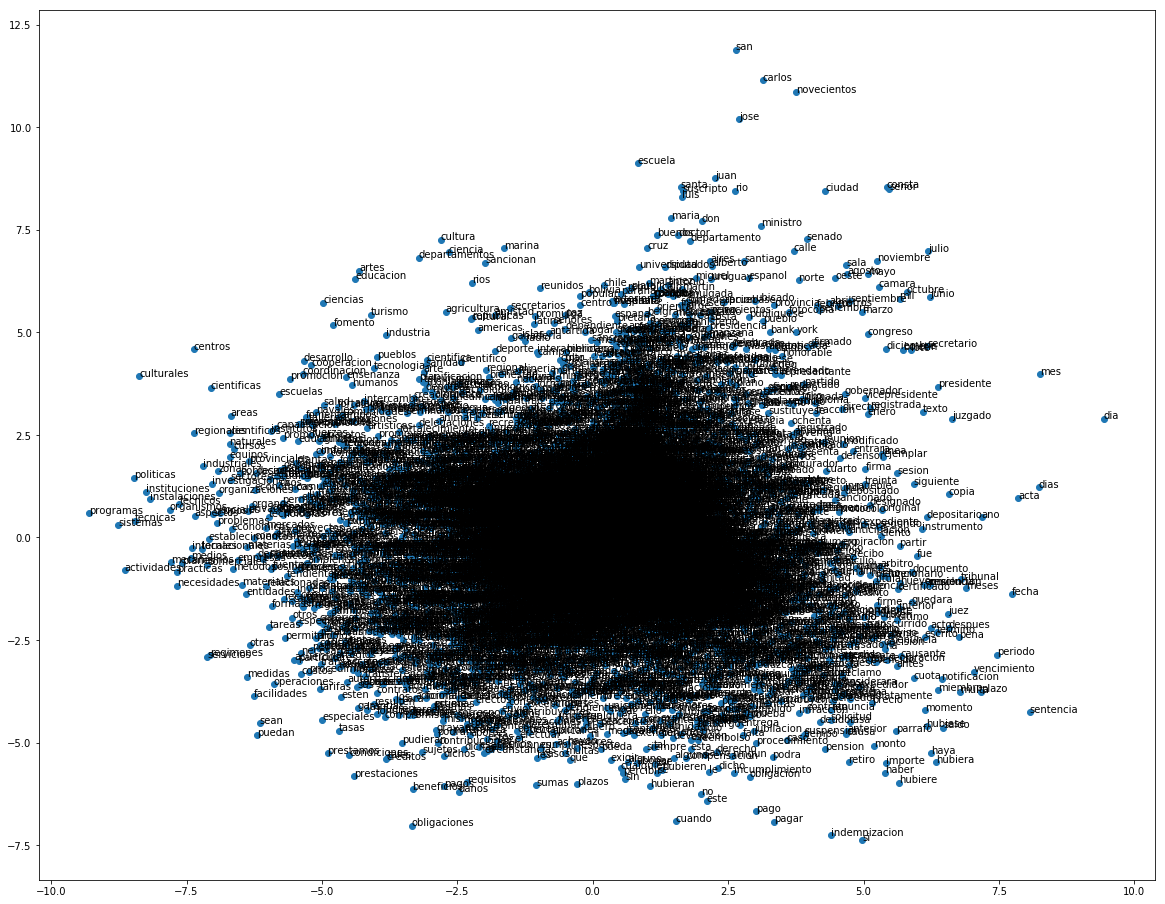

In [15]:
palabras = model[model.wv.vocab]
pca = sk.decomposition.PCA(n_components=2)
result = pca.fit_transform(palabras)

from matplotlib import pyplot
pyplot.figure(figsize=(20,16))
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

Si bien es dificil apreciar la ubicación de las palabras en el nuevo espacio viendo nada más que 2 dimensiones, se puede ver algún sentido semántico en las distancias. 

Otra cosa que se puede ver es analizar palabras más cercanas a una dada, para ello podemos utilizar la función ``wv.most_similar`` del modelo y probar con algunos ejemplos.

In [16]:
model.wv.most_similar('urquiza', topn=6)

/home/gzigaran/anaconda2/envs/CETA/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pinto', 0.9186417460441589),
 ('mitre', 0.9169003367424011),
 ('lavalle', 0.9093710780143738),
 ('alvear', 0.9054791331291199),
 ('guemes', 0.9000505805015564),
 ('roca', 0.8931492567062378)]

In [17]:
model.wv.most_similar('cordoba', topn=6)

/home/gzigaran/anaconda2/envs/CETA/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('mendoza', 0.927946925163269),
 ('tucuman', 0.9209545850753784),
 ('formosa', 0.9158689975738525),
 ('jujuy', 0.9076728820800781),
 ('salta', 0.898383617401123),
 ('catamarca', 0.8866009712219238)]

In [18]:
model.wv.most_similar('enero', topn=12)

/home/gzigaran/anaconda2/envs/CETA/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('abril', 0.8247718811035156),
 ('marzo', 0.8149340748786926),
 ('diciembre', 0.8109450340270996),
 ('junio', 0.8003301620483398),
 ('julio', 0.7861112356185913),
 ('octubre', 0.7807573080062866),
 ('mayo', 0.7691410183906555),
 ('agosto', 0.7673766613006592),
 ('septiembre', 0.763545036315918),
 ('noviembre', 0.7615313529968262),
 ('setiembre', 0.7484636306762695),
 ('febrero', 0.734600841999054)]

In [19]:
model.wv.most_similar('diputados', topn=6)

/home/gzigaran/anaconda2/envs/CETA/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('senado', 0.5817766189575195),
 ('fria', 0.5186717510223389),
 ('senadores', 0.5140507817268372),
 ('sanciona', 0.48612019419670105),
 ('promulgacon', 0.48134276270866394),
 ('solveyra', 0.47387614846229553)]

Sí se puede observar una similitud en el significado de la palabra, por lo que sería mucho mas conveniente representar a cada palabra por su vector de 100 dimensiones. Con esto presente ahora hay que proponer como representar todo un texto. Para ellos vamos a considerar 2 métodos, que están basados en la vectorización tradicional de un corpus de texto sin embedding:

 - Por un lado, considerar la media de los arreglos de todas las palabras que aparezcan en el texto.
 - Por otro lado, utilizanco el vectorizador ``TfidfVectorizer``, primero le asignamos a cada palabra un peso de acuerdo a cuantas veces aparece en el texto relativo a cuanto aparece en todo el dataset y luego calculamos una media pesada. 
 
Para cualquiera de los 2 casos, no hace falta utilizar todo el modelo aprendido sino sólamente el vector de cada palabra del corpus, por lo que vamos a generar un diccionario con esta información y utilizarlo para los vectorizadores.

In [20]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))
import pickle
pickle.dump(w2v, open("w2v.txt", "wb"))

/home/gzigaran/anaconda2/envs/CETA/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [21]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        from sklearn.feature_extraction.text import TfidfVectorizer
        from collections import defaultdict
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])


Estos vectorizadores funcionan muy parecidos a los provistos en ``sklearn.feature_extraction.text.CountVectorizer`` y ``sklearn.feature_extraction.text.TfidfVectorizer``, y los vamos a utilizar para crear el ``Pipeline`` para clusterizar con ``Kmeans``. 

Para evaluar los clusters generados, vamos a utilizar casos testigos a partir de las etiquetas que traen los datos. Vamos a usar 2 tipos de pares testigos, por un lado los pares en los que deberían estar en el mismo cluster por su similitud, y por otro lado el par de casos que deberían estar en clusters distintos por ser muy diferentes.

Para ello nos creamos 2 listas, la primera con todos los pares de casos en donde tengan más de 5 etiquetas y sean todas iguales. Para la segunda lista, tomamos todos los pares de casos en donde tengan más de 9 etiquetas y sean todas diferentes.

In [22]:
data.etiquetas = data.etiquetas.apply(lambda x: x.split(', '))

In [23]:
iguales = []
etiquetas_mas_5 = data[data.etiquetas.apply(lambda x: len(x) > 5)]
print(len(etiquetas_mas_5))
for i in etiquetas_mas_5.index:
    for j in etiquetas_mas_5.index:
        if i < j and set(data.loc[i].etiquetas) == set(data.loc[j].etiquetas):
            iguales.append((i,j))
len(iguales)

696


60

In [24]:
diferentes = []
etiquetas_mas_9 = data[data.etiquetas.apply(lambda x: len(x) > 9)]
print(len(etiquetas_mas_9))
for i in etiquetas_mas_9.index:
    for j in etiquetas_mas_9.index:
        if i < j and set(data.loc[i].etiquetas).isdisjoint(data.loc[j].etiquetas):
            diferentes.append((i,j))
len(diferentes)

55


1260

Con estas 2 listas definimos la función que analiza cuantos de estos casos cumple con el requisito de estar en el mismo o en diferente cluster.

In [25]:
def check_testigos(iguales, diferentes, data):
    ig_mal = []
    for (a, b) in iguales:
        if data.loc[a] != data.loc[b]:
            ig_mal.append((a, b))
    print('Hay %i coincidencias de %i dadas sobre testigos iguales' % (len(iguales) - len(ig_mal), len(iguales)))
    dif_mal = []
    for (a, b) in diferentes:
        if data.loc[a] == data.loc[b]:
            dif_mal.append((a, b))
    print('Hay %i coincidencias de %i dadas sobre testigos diferentes' % (len(diferentes) - len(dif_mal), len(diferentes)))
#     return (ig_mal, dif_mal)

In [26]:
data.texto = data.texto.swifter.apply(lambda x: tokenize_words(x))

Creamos una función que separe el dataset en *n* clusters con ``KMeans`` con los 2 vectorizadores, y luego analice los casos testigos.

In [27]:
def train_kmeans(num_clusters):
    from sklearn.pipeline import Pipeline
    from sklearn.cluster import KMeans
    kmeans_w2v = Pipeline([
        ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
        ("kmeans", KMeans(n_clusters=num_clusters, n_jobs=-1, max_iter=600, tol=0.000001))])
    kmeans_w2v_tfidf = Pipeline([
        ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
        ("kmeans", KMeans(n_clusters=num_clusters, n_jobs=-1, max_iter=600, tol=0.000001))])

    kmeans_w2v.fit(data.texto)
    kmeans_w2v_tfidf.fit(data.texto)
    clusters = kmeans_w2v.named_steps['kmeans'].labels_.tolist()
    clusters_tfidf = kmeans_w2v_tfidf.named_steps['kmeans'].labels_.tolist()
    for i in range(np.max(clusters) + 1):
        print ('El cluster %i tiene %i elementos' % (i, clusters.count(i)))
    for i in range(np.max(clusters_tfidf) + 1):
        print ('El cluster_tfidf %i tiene %i elementos' % (i, clusters_tfidf.count(i)))
    data['cluster'] = clusters
    data['clusters_tfidf'] = clusters_tfidf
    check_testigos(iguales, diferentes, data.cluster)
    check_testigos(iguales, diferentes, data.clusters_tfidf)
    

In [28]:
train_kmeans(2)

El cluster 0 tiene 2572 elementos
El cluster 1 tiene 4466 elementos
El cluster_tfidf 0 tiene 4394 elementos
El cluster_tfidf 1 tiene 2644 elementos
Hay 57 coincidencias de 60 dadas sobre testigos iguales
Hay 0 coincidencias de 1260 dadas sobre testigos diferentes
Hay 56 coincidencias de 60 dadas sobre testigos iguales
Hay 51 coincidencias de 1260 dadas sobre testigos diferentes


Separando en 2 clusters, podemos ver que respeta bastante bien los casos que deberían estar en el mismo grupo (57 de los 60 pares se respetan), pero no sucede lo mismo para los pares que deberían estar separados.

Esto puede deberse a que la estructura en clusters(si es que la hay), tiene varios grupos más y al forzar el algoritmo a separarlo en 2 clusters, termina juntando muchos grupos que en principio no tenian nada que ver. 

In [29]:
train_kmeans(3)

El cluster 0 tiene 2214 elementos
El cluster 1 tiene 3280 elementos
El cluster 2 tiene 1544 elementos
El cluster_tfidf 0 tiene 3287 elementos
El cluster_tfidf 1 tiene 2265 elementos
El cluster_tfidf 2 tiene 1486 elementos
Hay 56 coincidencias de 60 dadas sobre testigos iguales
Hay 649 coincidencias de 1260 dadas sobre testigos diferentes
Hay 56 coincidencias de 60 dadas sobre testigos iguales
Hay 632 coincidencias de 1260 dadas sobre testigos diferentes


In [30]:
train_kmeans(4)

El cluster 0 tiene 2399 elementos
El cluster 1 tiene 1457 elementos
El cluster 2 tiene 1276 elementos
El cluster 3 tiene 1906 elementos
El cluster_tfidf 0 tiene 1707 elementos
El cluster_tfidf 1 tiene 2111 elementos
El cluster_tfidf 2 tiene 1779 elementos
El cluster_tfidf 3 tiene 1441 elementos
Hay 55 coincidencias de 60 dadas sobre testigos iguales
Hay 665 coincidencias de 1260 dadas sobre testigos diferentes
Hay 55 coincidencias de 60 dadas sobre testigos iguales
Hay 953 coincidencias de 1260 dadas sobre testigos diferentes


In [31]:
train_kmeans(5)

El cluster 0 tiene 1827 elementos
El cluster 1 tiene 869 elementos
El cluster 2 tiene 2329 elementos
El cluster 3 tiene 781 elementos
El cluster 4 tiene 1232 elementos
El cluster_tfidf 0 tiene 534 elementos
El cluster_tfidf 1 tiene 1725 elementos
El cluster_tfidf 2 tiene 1428 elementos
El cluster_tfidf 3 tiene 1566 elementos
El cluster_tfidf 4 tiene 1785 elementos
Hay 55 coincidencias de 60 dadas sobre testigos iguales
Hay 718 coincidencias de 1260 dadas sobre testigos diferentes
Hay 55 coincidencias de 60 dadas sobre testigos iguales
Hay 947 coincidencias de 1260 dadas sobre testigos diferentes


In [32]:
train_kmeans(6)

El cluster 0 tiene 1634 elementos
El cluster 1 tiene 1339 elementos
El cluster 2 tiene 1108 elementos
El cluster 3 tiene 797 elementos
El cluster 4 tiene 1341 elementos
El cluster 5 tiene 819 elementos
El cluster_tfidf 0 tiene 1304 elementos
El cluster_tfidf 1 tiene 1401 elementos
El cluster_tfidf 2 tiene 1358 elementos
El cluster_tfidf 3 tiene 1384 elementos
El cluster_tfidf 4 tiene 755 elementos
El cluster_tfidf 5 tiene 836 elementos
Hay 54 coincidencias de 60 dadas sobre testigos iguales
Hay 963 coincidencias de 1260 dadas sobre testigos diferentes
Hay 48 coincidencias de 60 dadas sobre testigos iguales
Hay 963 coincidencias de 1260 dadas sobre testigos diferentes


In [33]:
train_kmeans(7)

El cluster 0 tiene 723 elementos
El cluster 1 tiene 1209 elementos
El cluster 2 tiene 1273 elementos
El cluster 3 tiene 772 elementos
El cluster 4 tiene 992 elementos
El cluster 5 tiene 1236 elementos
El cluster 6 tiene 833 elementos
El cluster_tfidf 0 tiene 716 elementos
El cluster_tfidf 1 tiene 1030 elementos
El cluster_tfidf 2 tiene 1467 elementos
El cluster_tfidf 3 tiene 814 elementos
El cluster_tfidf 4 tiene 1194 elementos
El cluster_tfidf 5 tiene 498 elementos
El cluster_tfidf 6 tiene 1319 elementos
Hay 54 coincidencias de 60 dadas sobre testigos iguales
Hay 956 coincidencias de 1260 dadas sobre testigos diferentes
Hay 50 coincidencias de 60 dadas sobre testigos iguales
Hay 963 coincidencias de 1260 dadas sobre testigos diferentes


In [34]:
train_kmeans(8)

El cluster 0 tiene 731 elementos
El cluster 1 tiene 825 elementos
El cluster 2 tiene 743 elementos
El cluster 3 tiene 1259 elementos
El cluster 4 tiene 1184 elementos
El cluster 5 tiene 301 elementos
El cluster 6 tiene 1235 elementos
El cluster 7 tiene 760 elementos
El cluster_tfidf 0 tiene 228 elementos
El cluster_tfidf 1 tiene 800 elementos
El cluster_tfidf 2 tiene 453 elementos
El cluster_tfidf 3 tiene 1531 elementos
El cluster_tfidf 4 tiene 1478 elementos
El cluster_tfidf 5 tiene 1364 elementos
El cluster_tfidf 6 tiene 658 elementos
El cluster_tfidf 7 tiene 526 elementos
Hay 54 coincidencias de 60 dadas sobre testigos iguales
Hay 956 coincidencias de 1260 dadas sobre testigos diferentes
Hay 51 coincidencias de 60 dadas sobre testigos iguales
Hay 941 coincidencias de 1260 dadas sobre testigos diferentes


In [35]:
train_kmeans(9)

El cluster 0 tiene 636 elementos
El cluster 1 tiene 294 elementos
El cluster 2 tiene 1060 elementos
El cluster 3 tiene 765 elementos
El cluster 4 tiene 871 elementos
El cluster 5 tiene 1115 elementos
El cluster 6 tiene 885 elementos
El cluster 7 tiene 691 elementos
El cluster 8 tiene 721 elementos
El cluster_tfidf 0 tiene 648 elementos
El cluster_tfidf 1 tiene 1183 elementos
El cluster_tfidf 2 tiene 1049 elementos
El cluster_tfidf 3 tiene 218 elementos
El cluster_tfidf 4 tiene 448 elementos
El cluster_tfidf 5 tiene 685 elementos
El cluster_tfidf 6 tiene 510 elementos
El cluster_tfidf 7 tiene 1286 elementos
El cluster_tfidf 8 tiene 1011 elementos
Hay 55 coincidencias de 60 dadas sobre testigos iguales
Hay 992 coincidencias de 1260 dadas sobre testigos diferentes
Hay 53 coincidencias de 60 dadas sobre testigos iguales
Hay 1040 coincidencias de 1260 dadas sobre testigos diferentes


In [36]:
train_kmeans(10)

El cluster 0 tiene 951 elementos
El cluster 1 tiene 290 elementos
El cluster 2 tiene 994 elementos
El cluster 3 tiene 677 elementos
El cluster 4 tiene 747 elementos
El cluster 5 tiene 759 elementos
El cluster 6 tiene 592 elementos
El cluster 7 tiene 917 elementos
El cluster 8 tiene 457 elementos
El cluster 9 tiene 654 elementos
El cluster_tfidf 0 tiene 433 elementos
El cluster_tfidf 1 tiene 639 elementos
El cluster_tfidf 2 tiene 681 elementos
El cluster_tfidf 3 tiene 216 elementos
El cluster_tfidf 4 tiene 1025 elementos
El cluster_tfidf 5 tiene 723 elementos
El cluster_tfidf 6 tiene 1052 elementos
El cluster_tfidf 7 tiene 420 elementos
El cluster_tfidf 8 tiene 995 elementos
El cluster_tfidf 9 tiene 854 elementos
Hay 54 coincidencias de 60 dadas sobre testigos iguales
Hay 1006 coincidencias de 1260 dadas sobre testigos diferentes
Hay 53 coincidencias de 60 dadas sobre testigos iguales
Hay 1040 coincidencias de 1260 dadas sobre testigos diferentes


In [37]:
train_kmeans(11)

El cluster 0 tiene 188 elementos
El cluster 1 tiene 812 elementos
El cluster 2 tiene 973 elementos
El cluster 3 tiene 684 elementos
El cluster 4 tiene 730 elementos
El cluster 5 tiene 952 elementos
El cluster 6 tiene 757 elementos
El cluster 7 tiene 341 elementos
El cluster 8 tiene 828 elementos
El cluster 9 tiene 479 elementos
El cluster 10 tiene 294 elementos
El cluster_tfidf 0 tiene 265 elementos
El cluster_tfidf 1 tiene 631 elementos
El cluster_tfidf 2 tiene 716 elementos
El cluster_tfidf 3 tiene 972 elementos
El cluster_tfidf 4 tiene 367 elementos
El cluster_tfidf 5 tiene 1062 elementos
El cluster_tfidf 6 tiene 688 elementos
El cluster_tfidf 7 tiene 209 elementos
El cluster_tfidf 8 tiene 706 elementos
El cluster_tfidf 9 tiene 441 elementos
El cluster_tfidf 10 tiene 981 elementos
Hay 55 coincidencias de 60 dadas sobre testigos iguales
Hay 1006 coincidencias de 1260 dadas sobre testigos diferentes
Hay 52 coincidencias de 60 dadas sobre testigos iguales
Hay 1054 coincidencias de 1260

In [38]:
train_kmeans(12)

El cluster 0 tiene 750 elementos
El cluster 1 tiene 689 elementos
El cluster 2 tiene 364 elementos
El cluster 3 tiene 808 elementos
El cluster 4 tiene 899 elementos
El cluster 5 tiene 390 elementos
El cluster 6 tiene 689 elementos
El cluster 7 tiene 293 elementos
El cluster 8 tiene 469 elementos
El cluster 9 tiene 671 elementos
El cluster 10 tiene 838 elementos
El cluster 11 tiene 178 elementos
El cluster_tfidf 0 tiene 545 elementos
El cluster_tfidf 1 tiene 967 elementos
El cluster_tfidf 2 tiene 68 elementos
El cluster_tfidf 3 tiene 999 elementos
El cluster_tfidf 4 tiene 426 elementos
El cluster_tfidf 5 tiene 432 elementos
El cluster_tfidf 6 tiene 213 elementos
El cluster_tfidf 7 tiene 672 elementos
El cluster_tfidf 8 tiene 1014 elementos
El cluster_tfidf 9 tiene 482 elementos
El cluster_tfidf 10 tiene 855 elementos
El cluster_tfidf 11 tiene 365 elementos
Hay 53 coincidencias de 60 dadas sobre testigos iguales
Hay 1045 coincidencias de 1260 dadas sobre testigos diferentes
Hay 47 coinci

In [39]:
train_kmeans(13)

El cluster 0 tiene 322 elementos
El cluster 1 tiene 177 elementos
El cluster 2 tiene 870 elementos
El cluster 3 tiene 390 elementos
El cluster 4 tiene 772 elementos
El cluster 5 tiene 860 elementos
El cluster 6 tiene 266 elementos
El cluster 7 tiene 342 elementos
El cluster 8 tiene 528 elementos
El cluster 9 tiene 494 elementos
El cluster 10 tiene 702 elementos
El cluster 11 tiene 679 elementos
El cluster 12 tiene 636 elementos
El cluster_tfidf 0 tiene 923 elementos
El cluster_tfidf 1 tiene 694 elementos
El cluster_tfidf 2 tiene 614 elementos
El cluster_tfidf 3 tiene 429 elementos
El cluster_tfidf 4 tiene 681 elementos
El cluster_tfidf 5 tiene 362 elementos
El cluster_tfidf 6 tiene 671 elementos
El cluster_tfidf 7 tiene 210 elementos
El cluster_tfidf 8 tiene 68 elementos
El cluster_tfidf 9 tiene 424 elementos
El cluster_tfidf 10 tiene 951 elementos
El cluster_tfidf 11 tiene 540 elementos
El cluster_tfidf 12 tiene 471 elementos
Hay 45 coincidencias de 60 dadas sobre testigos iguales
Hay

In [40]:
train_kmeans(14)

El cluster 0 tiene 881 elementos
El cluster 1 tiene 421 elementos
El cluster 2 tiene 311 elementos
El cluster 3 tiene 526 elementos
El cluster 4 tiene 387 elementos
El cluster 5 tiene 735 elementos
El cluster 6 tiene 260 elementos
El cluster 7 tiene 630 elementos
El cluster 8 tiene 683 elementos
El cluster 9 tiene 127 elementos
El cluster 10 tiene 401 elementos
El cluster 11 tiene 177 elementos
El cluster 12 tiene 865 elementos
El cluster 13 tiene 634 elementos
El cluster_tfidf 0 tiene 553 elementos
El cluster_tfidf 1 tiene 576 elementos
El cluster_tfidf 2 tiene 605 elementos
El cluster_tfidf 3 tiene 720 elementos
El cluster_tfidf 4 tiene 598 elementos
El cluster_tfidf 5 tiene 207 elementos
El cluster_tfidf 6 tiene 689 elementos
El cluster_tfidf 7 tiene 68 elementos
El cluster_tfidf 8 tiene 508 elementos
El cluster_tfidf 9 tiene 370 elementos
El cluster_tfidf 10 tiene 451 elementos
El cluster_tfidf 11 tiene 425 elementos
El cluster_tfidf 12 tiene 876 elementos
El cluster_tfidf 13 tiene

In [41]:
train_kmeans(15)

El cluster 0 tiene 313 elementos
El cluster 1 tiene 169 elementos
El cluster 2 tiene 255 elementos
El cluster 3 tiene 713 elementos
El cluster 4 tiene 757 elementos
El cluster 5 tiene 685 elementos
El cluster 6 tiene 520 elementos
El cluster 7 tiene 476 elementos
El cluster 8 tiene 260 elementos
El cluster 9 tiene 318 elementos
El cluster 10 tiene 645 elementos
El cluster 11 tiene 179 elementos
El cluster 12 tiene 461 elementos
El cluster 13 tiene 645 elementos
El cluster 14 tiene 642 elementos
El cluster_tfidf 0 tiene 548 elementos
El cluster_tfidf 1 tiene 442 elementos
El cluster_tfidf 2 tiene 219 elementos
El cluster_tfidf 3 tiene 771 elementos
El cluster_tfidf 4 tiene 369 elementos
El cluster_tfidf 5 tiene 549 elementos
El cluster_tfidf 6 tiene 552 elementos
El cluster_tfidf 7 tiene 393 elementos
El cluster_tfidf 8 tiene 206 elementos
El cluster_tfidf 9 tiene 64 elementos
El cluster_tfidf 10 tiene 548 elementos
El cluster_tfidf 11 tiene 672 elementos
El cluster_tfidf 12 tiene 714 e

En general los casos testigos quedan bastante bien representados en la mayoría de los casos. No se ve una configuración que funcione significativamente mejor que las otras, sino que al aumentar el numero de clusters lo que sucede es que disminuye la cantidad de coincidencias para los pares que esperaríamos que esten juntos y aumenta el número de pares correctos que se esperan en clusters distintos, algo que suena lógico.

En cuanto al balance de los clusters, se observa que en todos los casos no hay un cluster muy mayoritario o clusters prácticamente nulos, por lo que  es bastante positivo también.

La vectorización con ``tfidf`` parece ser mejor, o al menos se suele comportar mejor para los casos testigos. 

Vamos a utilizar esta vectorización y 12 clusters para analizar los centroides y sus elementos más cercanos. 

In [42]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

kmeans_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("kmeans", KMeans(n_clusters=12, n_jobs=-1, max_iter=600, tol=0.000001))])

kmeans_w2v_tfidf.fit(data.texto)

Pipeline(memory=None,
     steps=[('word2vec vectorizer', <__main__.TfidfEmbeddingVectorizer object at 0x7fb235d5e400>), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=12, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=1e-06, verbose=0))])

In [44]:
d = kmeans_w2v_tfidf.transform(data.texto)
ind = np.zeros((5,12))
for i in range(12):
    ind[:,i] = np.argsort(d[:,i])[::][:5]
ind.shape
pd.set_option('display.max_colwidth', 150)

Con los clusters construidos, vamos a analizar cada centroide y sus 5 elementos más cercanos para poder sacar algunas conclusiones a partir de la similitudes:

In [45]:
data[['titulo_resumido', 'titulo_sumario', 'texto_resumido']].iloc[ind[:,0]]

,titulo_resumido,titulo_sumario,texto_resumido
16653,VICARIOS CAPITULARES O ADMINISTRADORES APOSTOLICOS - ASIGNACION MENSUAL,CULTO,"EN LOS CASOS DE VACANCIAS DE LA TITULARIADAD PRODUCIDA EN LA ARQUIDIOSIS, PRELATURAS,EPARQUIAS Y EXARCADOS DEL CULTO CATOLICO Y HASTA SE DESIGNE N..."
11289,NaN,CENSO ESCOLAR:ALCANCES,OBJETO CUMPLIDO LEY MODIFICATORIA DE LA LEY 12723-PRORROGA PARA REALIZACION DEL CENSO ESCOLAR
25257,MURAL EJERCICIO PLASTICO,OBRAS DE ARTE,"DECLARASE DE UTILIDAD PUBLICA Y SUJETO A EXPROPIACION EL MURAL EJERCICIO PLASTICO, REALIZADO POR EL ARTISTA MEJICANO DAVID ALFARO SIQUEIROS, CON..."
16921,IMPUESTO A LOS HIPODROMOS-IMPUESTO SOBRE LA VENTA DE BOLETAS DE APUESTAS,APUESTAS HIPICAS,LEY MODIFICATORIA Y OBJETO CUMPLIDO-IMPUESTO SOBRE EL PRODUCTO DE LA VENTA DE LOS BOLETOS DE APUESTAS EN LOS HIPODROMOS NACIONALES- MODIFICA LEY 1...
25517,VACUNA BACILO DE CALMETTE Y GUERIN (BCG) - INCORPORASE AL PLAN MATERNO INFANTIL,SALUD PUBLICA,INCORPORASE AL PLAN MATERNO INFANTIL LA VACUNA BACILO DE CALMETTE Y GUERIN (BCG) PARA LA POBLACION PEDIATRICA DEL TERRITORIO NACIONAL.


En el **cluster 0**, no está muy claro pero se observan textos sobre cultura o niñez.

In [46]:
data[['titulo_resumido', 'titulo_sumario', 'texto_resumido']].iloc[ind[:,1]]

,titulo_resumido,titulo_sumario,texto_resumido
26131,CREACION,REGIMEN DE PROMOCION DE LA INDUSTRIA NAVAL ARGENTINA,"CREASE EL REGIMEN DE INCENTIVO, PROMOCION Y DESARROLLO DE LA INDUSTRIA NAVAL ARGENTINA QUE SE REGIRA CON LOS ALCANCES Y LIMITACIONES ESTABLECIDOS ..."
21023,CAMPEONATOS MUNDIALES DE FUTBOL-ENTE AUTARQUICO MUNDIAL 78,DEPORTES,OBJETO CUMPLIDO-DEPORTES-DECLARA DE INTERES NACIONAL-CREA ENTE AUTARTICO MUNDIAL 1978
14567,CONSEJO DE LA ADMINISTRACION NACIONAL,BOSQUES,MODIFICASE LA CONSTITUCION DEL CONSEJO DE LA ADMINISTRACION NACIONAL DE BOSQUES
24378,SU CREACION,INSTITUTO NACIONAL DE LA YERBA MATE,"CREACION DEL INSTITUTO NACIONAL DE LA YERBA MATE, COMO ENTE DE DERECHO PUBLICO NO ESTATAL CON JURISDICCION EN TODO EL TERRITORIO DE LA REPUBLICA A..."
22928,PROMOCION Y FOMENTO,INNOVACION TECNOLOGICA,"SE DETERMINAN LOS OBJETIVOS, BENEFICIARIOS Y AUTORIDAD DE APLICACION DEL PROGRAMA DESTINADO A LA PROMOCION Y FOMENTO DE LA INNOVACION TECNOLOGICA...."


En el **cluster 1**, si bien los textos no parecen estar muy relacionados, parecen tratar el tema de la *promoción o fomento* de alguna manera.

In [47]:
data[['titulo_resumido', 'titulo_sumario', 'texto_resumido']].iloc[ind[:,2]]

,titulo_resumido,titulo_sumario,texto_resumido
25227,JUZGADO FEDERAL DE PRIMERA INSTANCIA - CREACION,JUSTICIA,"CREASE UN JUZGADO FEDERAL DE PRIMERA INSTANCIA DE FUERO UNIVERSAL CON ASIENTO EN LA CIUDAD DE GOYA, PROVINCIA DE CORRIENTES, CON JURISDICCION TERR..."
23053,JUZGADO FEDERAL DE PRIMERA INSTANCIA - CREACION,JUSTICIA,CREASE UN JUZGADO FEDERAL DE 1RA. INSTANCIA CON ASIENTO EN LA CIUDAD DE FORMOSA.
25354,PODER JUDICIAL DE LA NACION - CREACION DE DEPENDENCIAS Y CARGOS,MINISTERIO PUBLICO,"CREANSE TRIBUNALES ORALES EN LO CRIMINAL FEDERAL, FISCALIAS GENERALES, DEFENSORIAS PUBLICAS OFICIALES Y LOS CARGOS DE MAGISTRADOS, FUNCIONARIOS Y ..."
25683,JUZGADO FEDERAL DE PRIMERA INSTANCIA EN LO FEDERAL - CREACION,JUSTICIA,"CREASE EL JUZGADO FEDERAL DE PRIMERA INSTANCIA EN LO FEDERAL, EN LA CIUDAD DE GUALEGUAYCHU, PROVINCIA DE ENTRE RIOS."
25361,"JUZGADO FEDERAL, FISCALIA Y DEFENSORIA PUBLICA EN ENTRE RIOS- CREACION",JUSTICIA,"CREANSE UN JUZGADO FEDERAL, UNA FISCALIA Y UNA DEFENSORIA PUBLICA OFICIAL EN LA PROVINCIA DE ENTRE RIOS."


En el **cluster 2**, los 5 elementos más cercanos al centroide están relacionados con temas de la justicia, en este caso todos sobre la creación de juzgados.

In [48]:
data[['titulo_resumido', 'titulo_sumario', 'texto_resumido']].iloc[ind[:,3]]

,titulo_resumido,titulo_sumario,texto_resumido
24541,COOPERACION ENERGETICA,ACUERDOS,APRUEBASE EL ACUERDO SOBRE COOPERACION ENERGETICA SUSCRIPTO CON LA REPUBLICA BOLIVARIANA DE VENEZUELA.
22987,TURISMO -CONVENIO CON BOLIVIA-,NaN,SE APRUEBA EL CONVENIO DE COOPERACION Y FACILITACION EN MATERIA DE TURISMO CON LA REPUBLICA DE BOLIVIA SUSCRIPTO EL 13-12-89. PROMULGADA POR DEC. ...
24356,COOPERACION EN MATERIA AGROINDUSTRIAL (ARMENIA),ACUERDOS,APRUEBASE UN ACUERDO DE COOPERACION EN MATERIA AGROINDUSTRIAL SUSCRIPTO CON EL GOBIERNO DE LA REPUBLICA DE ARMENIA.
22988,ACUERDO DE COOPERACION ECONOMICA CON ANGOLA,NaN,"SE APRUEBA UN ACUERDO GENERAL DE COOPERACION ECONOMICA, TECNICA, CIENTIFICA Y CULTURAL SUSCRIPTO CON LA REPUBLICA POPULAR DE ANGOLA, EL 16-4-88. P..."
21328,CONVENIO DE COOPERACION CIENTIFICA Y TECNOLOGICA CON RUMANIA - APROBACION,TRATADOS INTERNACIONALES,"APRUEBASE EL ""CONVENIO DE COOPERACION CIENTIFICA Y TECNOLOGICA ENTRE EL GOBIERNO DE LA REPUBLICA ARGENTINA Y EL GOBIERNO DE LA REPUBLICA SOCIALIST..."


En el **cluster 3**, los elementos cercanos al centroide tratan sobre acuerdos o convenios internacionales.

In [49]:
data[['titulo_resumido', 'titulo_sumario', 'texto_resumido']].iloc[ind[:,4]]

,titulo_resumido,titulo_sumario,texto_resumido
25967,PROGRAMA NACIONAL - CREACION,REPARACION HISTORICA PARA JUBILADOS Y PENSIONADOS,"CREASE EL PROGRAMA NACIONAL DE REPARACION HISTORICA PARA JUBILADOS Y PENSIONADOS, CON EL OBJETO DE IMPLEMENTAR ACUERDOS QUE PERMITAN REAJUSTAR LOS..."
25970,REGIMEN DE REINTEGRO POR COMPRAS EN COMERCIOS DE VENTA MINORISTA,IMPUESTO AL VALOR AGREGADO,"ESTABLECESE UN REGIMEN DE REINTEGRO DE UNA PROPORCION DEL IMPUESTO AL VALOR AGREGADO CONTENIDO EN EL MONTO DE LAS OPERACIONES QUE, EN CARACTER DE ..."
22669,REGIMEN TRANSITORIO,COPARTICIPACION FEDERAL,"ESTABLECESE EL REGIMEN TRANSITORIO DE DISTRIBUCION ENTRE LA NACION Y LA PROVINCIAS, A PARTIR DEL 1.1.88."
12410,PERSONAL BANCARIO-EMPRESA DE SEGUROS,CAJAS DE JUBILACION,RATIFICA DL 23.682-44-CAJA NACIONAL DE JUBILACIONES DE PERSONAL BANCARIO-OBJETO CUMPLIDO
25455,APROBACION EJERCICIO 2012,PRESUPUESTO GENERAL DE LA ADMINISTRACION NACIONAL,APRUEBASE EL PRESUPUESTO GENERAL DE LA ADMINISTRACION NACIONAL PARA EL EJERCICIO 2012.


En el **cluster 4**, no es tan marcado el tema en común que pueden tener los elementos más cercanos, pero todos tienen algo en común con impuestos o tarifas

In [50]:
data[['titulo_resumido', 'titulo_sumario', 'texto_resumido']].iloc[ind[:,5]]

,titulo_resumido,titulo_sumario,texto_resumido
23077,TRANSFERENCIA -TERRENO EN ITUZAINGO,INMUEBLES,"SE FACULTA AL PODER EJECUTIVO NACIONAL A TRANSFERIR UNA FRACCION DE TERRENO CON DESTINO A LA CONSTRUCCION DE UNA ESCUELA EN ITUZAINGO, PARTIDO DE ..."
22191,PODER EJECUTIVO NACIONAL - FACULTASE,TRANSFERENCIAS,FACÚLTASE AL PODER EJECUTIVO NACIONAL A DISPONER LA TRANSFERENCIA A TÍTULO GRATUITO DEL DOMINIO DE UNA FRACCIÓN DE TERRENO UBICADA EN EL PARTIDO D...
23156,TRANSFERENCIA GRATUITA INMUEBLES EN PROVINCIA DE ENTRE RIOS.,INMUEBLES,"TRANSFIERENSE INMUEBLES A TITULO GRATUITO A LA MUNICIPALIDAD DE LA CIUDAD DE CONCEPCION DEL URUGUAY, PCIA. DE ENTRE RIOS. PROMULGADA POR DEC. 1975..."
22032,PODER EJECUTIVO NACIONAL - FACULTASE,TRANSFERENCIAS,"FACULTASE AL PODER EJECUTIVO NACIONAL A TRANSFERIR A LA MUNICIPALIDAD DE GODOY CRUZ, DEPARTAMENTO DEL MISMO NOMBRE, PROVINCIA DE MENDOZA, UNA FRAC..."
23068,TRANSFERENCIA - INMUEBLE A LA MUNICIPALIDAD CHUBUT,INMUEBLES,"SE TRANSFIERE A TITULO GRATUTITO UN PREDIO UBICADO EN LA CIUDAD DE COMODORO RIVADAVIA, PCIA. DEL CHUBUT; A LA MUNICIPALIDAD DE LA CITADA CIUDAD. P..."


En el **cluster 5**, se observan textos relacionados a transferencias de inmuebles.

In [51]:
data[['titulo_resumido', 'titulo_sumario', 'texto_resumido']].iloc[ind[:,6]]

,titulo_resumido,titulo_sumario,texto_resumido
25687,FRAY MAMERTO ESQUIU - RECONOCIMIENTO,CONMEMORACIONES,RECONOZCASE A FRAY MAMERTO ESQUIU COMO UNA DE LAS PERSONALIDADES SOBRESALIENTES DEL BICENTENARIO DE LA PATRIA.
26090,CAPITAL NACIONAL DEL BASQUETBOL,DECLARACIONES OFICIALES,"DECLARASE COMO CAPITAL NACIONAL DEL BASQUETBOL A LA CIUDAD DE BAHIA BLANCA, PROVINCIA DE BUENOS AIRES."
26092,CAPITAL NACIONAL DEL ASADO CON CUERO,DECLARACIONES OFICIALES,"DECLARESE CAPITAL NACIONAL DEL ASADO CON CUERO A LA CIUDAD DE VIALE, DEPARTAMENTO DE PARANA, PROVINCIA DE ENTRE RIOS."
25974,CAPITAL NACIONAL DE PELOTA A PALETA,DECLARACIONES OFICIALES,"DECLARESE CAPITAL NACIONAL DE PELOTA A PALETA A LA LOCALIDAD DE VENADO TUERTO, DEPARTAMENTO DE GENERAL LOPEZ, PROVINCIA DE SANTA FE."
10441,LEVANTAMIENTO DEL ESTADO DE SITIO,ESTADO DE SITIO,OBJETO CUMPLIDO-APRUEBA EL ESTABLECIMIENTO DEL ESTADO DE SITIO Y FIJA FECHA DE TERMINACION


En el **cluster 6**, los elementos cercanos al centroide están todos relacionados con días conmemorativos y fechas importantes.

In [52]:
data[['titulo_resumido', 'titulo_sumario', 'texto_resumido']].iloc[ind[:,7]]

,titulo_resumido,titulo_sumario,texto_resumido
13422,PRORROGA DE VIGENCIA DE LEY DE ALQUILERES,ARRENDAMIENTOS Y APARCERIAS RURALES,PRORROGASE CON VARIAS MODIFICACIONES LA VIGENCIA DE LA LEY DE ALQUILERES
24071,REGIMEN LEGAL,ETICA EN EL EJERCICIO DE LA FUNCION PUBLICA,"DEBERES, PROHIBICIONES E INCOMPATIBLIDADES APLICABLES, SIN EXCEPCION, A TODAS LAS PERSONAS QUE SE DESEMPEÑEN EN LA FUNCION PUBICA EN TODOS SUS NIV..."
25085,LEY N° 24.240 - MODIFICACION,DEFENSA DEL CONSUMIDOR,MODIFICACION DE LA LEY Nº 24.240. DISPOSICIONES COMPLEMENTARIAS; SUSTITUYESE EL TEXTO DEL ARTICULO 50 DE LA LEY N° 25.065 DE TARJETAS DE CREDITO; ...
20241,CONDICIONES HABILITANTES,MARTILLEROS,CONDICIONES HABILITANTES. DEROGANSE LOS ARTICULOS 113 Y 122 DEL CODIGO DE COMERCIO.
23665,MODIFICACION DE LA LEY 22435,AMNISTIAS,"MODIFICANSE LOS ARTICULOS 35, 36,37, 38 Y 39 DE LA LEY 22435, MODIFICATORIA DE SU SIMILAR 17671. AMNISTIAS.- JHS"


En el **cluster 7**, no parece tener una temática clara, sin embargo tampoco parecen ser textos parecidos a los de otros clusters.

In [53]:
data[['titulo_resumido', 'titulo_sumario', 'texto_resumido']].iloc[ind[:,8]]

,titulo_resumido,titulo_sumario,texto_resumido
9782,EJERCICIO 1921,PRESUPUESTO GENERAL DE LA ADMINISTRACION NACIONAL,DECLARASE EN VIGENCIA PARA EJERCICIO ECONOMICO DEL CORRIENTE AÑO LA LEY DE PRESUPUESTO NUMERO 11.027 E IMPOSITIVAS QUE RIGIERON DURANTE EL AÑO 1920.
2944,EJERCICIO 1901 - SU APROBACION,PRESUPUESTO GENERAL DE LA ADMINISTRACION NACIONAL,"EL PRESUPUESTO DE GASTOS DE LA ADMINISTRACION PARA 1901 QUEDA FIJADO EN LA SUMA DE 26.025.175,82 $ ORO Y 89.940.499,10 $ MONEDA DE CURSO LEGAL."
1009,EJERCICIO 1884 - SU APROBACION,PRESUPUESTO GENERAL DE LA ADMINISTRACION NACIONAL,"EL PRESUPUESTO GENERAL DE GASTOS PARA LA ADMINISTRACION EN EL AÑO ECONOMICO DE 1884, QUEDA FIJADO EN LA SUMA DE ($ 34.929,640-43 M/N.) TREINTA Y ..."
874,EJERCICIO 1882 - SU APROBACION,PRESUPUESTO GENERAL DE LA ADMINISTRACION NACIONAL,"EL PRESUPUESTO GENERAL DE GASTOS DE LA ADMINISTRACION PARA EL AÑO ECONOMICO DE 1882, QUEDA FIJADO EN LA SUMA DE VEINTE Y OCHO MILLONES, CIENTO CUA..."
3201,EJERCICIO 1904 - SU APROBACION,PRESUPUESTO GENERAL DE LA ADMINISTRACION NACIONAL,ARTICULO 1.º EL PRESUPUESTO GENERAL DE GASTOS DE LA ADMINISTRACION PARA EL EJERCICIO DE 1904 QUEDA FIJADO EN VEINTICINCO MILLONES QUINIENTOS NOVEN...


En el **cluster 8**, el centroide está cerca de los elementos relacionados a presupuestos.

In [54]:
data[['titulo_resumido', 'titulo_sumario', 'texto_resumido']].iloc[ind[:,9]]

,titulo_resumido,titulo_sumario,texto_resumido
25880,CONVENIO IBEROAMERICANO SOBRE EL USO DE LA VIDEOCONFERENCIA -APROBACION,CONVENIOS,"APRUEBASE EL CONVENIO IBEROAMERICANO SOBRE EL USO DE LA VIDEOCONFERENCIA EN LA COOPERACION INTERNACIONAL ENTRE SISTEMAS DE JUSTICIA, CELEBRADO EN ..."
25674,ACUERDO ENTRE LA REPUBLICA ARGENTINA Y LA REPUBLICA FEDERATIVA DE BRASIL,ACUERDOS,APRUEBASE ACUERDO ENTRE EL GOBIERNO DE LA REPUBLICA ARGENTINA Y EL GOBIERNO DE LA REPUBLICA FEDERATIVA DEL BRASIL.
26067,CONVENIO RELATIVO A GARANTIAS INTERNACIONALES SOBRE ELEMENTOS DE EQUIPO MOVIL - APRUEBASE,CONVENIOS,"APRUEBASE EL CONVENIO RELATIVO A GARANTIAS INTERNACIONALES SOBRE ELEMENTOS DE EQUIPO MOVIL SUSCRIPTO EN CIUDAD DEL CABO, REPUBLICA DE SUDAFRICA"
25669,SERVICIOS AEREOS ENTRE LA REPUBLICA ARGENTINA Y LA REPUBLICA DE INDONESIA,ACUERDOS,APRUEBASE ACUERDO SOBRE SERVICIOS AEREOS ENTRE EL GOBIERNO DE LA REPUBLICA ARGENTINA Y EL GOBIERNO DE LA REPUBLICA DE INDONESIA.
25745,ACUERDO DE COOPERACION EN MATERIA DE BECAS DE ESTUDIO - APRUEBASE,ACUERDOS,APRUEBASE EL ACUERDO DE COOPERACION ENTRE EL GOBIERNO DE LA REPUBLICA ARGENTINA Y EL GOBIERNO DE LA REPUBLICA BOLIVARIANA DE VENEZUELA EN MATERIA ...


En el **cluster 9**, los elementos cercanos al centroide tratan sobre acuerdos o convenios internacionales.

In [55]:
data[['titulo_resumido', 'titulo_sumario', 'texto_resumido']].iloc[ind[:,10]]

,titulo_resumido,titulo_sumario,texto_resumido
25832,PASO DE LOS PATOS - PROVINCIA DE SAN JUAN,LUGARES HISTORICOS NACIONALES,"DECLARASE LUGAR HISTORICO NACIONAL, AL PASO DE LOS PATOS, EN LA PROVINCIA DE SAN JUAN."
24056,"TRANSFERENCIA (BARILOCHE, RIO NEGRO)",INMUEBLES,"TRANSFIERENSE A FAVOR DEL MUNICIPIO DE SAN CARLOS DE BARILOCHE, PROVINCIA DE RIO NEGRO, LOS INMUEBLES PERTENECIENTES A LA ADMINISTRACION DE PARQUE..."
25022,FORTIN CORONEL BELISLE,MONUMENTOS HISTORICOS NACIONALES,"DECLARASE MONUMENTO HISTORICO NACIONAL EN LOS TERMINOS DE LA LEY Nº 12.665 Y SU MODIFICATORIA 24.252, EL DENOMINADO FORTIN CORONEL BELISLE, UBIC..."
25360,EDIFICIOS Y PREDIO DE LA ANTIGUA SINAGOGA Y EL SALON COMUNITARIO DE LA COLONIA RUSA,MONUMENTOS Y LUGARES HISTORICOS,DECLARASE LUGAR HISTORICO NACIONAL A LOS EDIFICIOS Y PREDIO DE LA ANTIGUA SINAGOGA Y EL SALON COMUNITARIO DE LA COLONIA RUSA SITO EN LA MUNICIPALI...
24152,LEY 24855 - MODIFICACION -,DESARROLLO REGIONAL Y GENERACION DE EMPLEO,INCLUYESE AL ART. 24 DE LA LEY 24855 UN INCISO RELACIONADO CON LA TRANSFERENCIA DE UN INMUEBLE.-


En el **cluster 10**, los elementos cercanos al centroide están relacionados con lugares o monumentos históricos.

In [56]:
data[['titulo_resumido', 'titulo_sumario', 'texto_resumido']].iloc[ind[:,11]]

,titulo_resumido,titulo_sumario,texto_resumido
16089,AHDESION - REPUBLICA ARGENTINA,ESTATUTOS DE LOS REFUGIADOS,"ADHESION ARGENTINA A LA CONVENCION RELATIVA AL ESTATUTO DE REFUGIADOS, SUSCRIPTO EN GINEBRA EL 28/7/51 Y A LA RESOLUCION 538/52 (VI) DE LA ASAMBLE..."
14287,CONVENIO DE LA UN - RATIFICACION,TRATADOS INTERNACIONALES,"SE RATIFICA EL CONVENIO PARA LA REPRESION DE LA TRATA DE PERSONAS Y DE LA EXPLOTACION DE LA PROSTITUCION AJENA, APROBADO EN LA 264º SESION PLENARI..."
22617,CONTAMINACION POR HIDROCARBUROS - SU APROBACION,CONVENIOS INTERNACIONALES,"APRUEBASE EL CONVENIO INTERNACIONAL SOBRE RESPONSABILIDAD CIVIL NACIDA DE DAÑOS DEBIDO A CONTAMINACION POR HIDROCARBUROS, SUSCRIPTO EN BRUSELAS EL..."
24175,COHECHO DE FUNCIONARIOS PUBLICOS (FRANCIA),CONVENCIONES,APRUEBASE LA CONVENCION SOBRE LA LUCHA CONTRA EL COHECHO DE FUNCIONARIOS PUBLICOS EXTRANJEROS EN LAS TRANSACCIONES COMERCIALES INTERNACIONALES SUS...
13290,PAZ,TRATADOS,APROBACION DE UN TRATADO DE PAZ SUSCRITO CON JAPON.


El **cluster 11** parece estar muy relacionado al **cluster 9** y al **cluster 3**, al tratar textos sobre tratados internacionales.